DEEP LEARNING

LAB-8

PRANSHU PARATE

202211063

OXFORD DATASET

Use Oxford pet dataset for this particular task of image segmentation

In [ ]:
#importing packages
import tensorflow as tf
#from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

In [ ]:
#load the dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete9UBR1D/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete9UBR1D/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmpdc75ixw5tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

In [ ]:
dataset

{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [ ]:
def normalize(image, mask):
  image = tf.cast(image, tf.float32)/255.
  mask -=1
  return image, mask

@tf.function
def load_image_train(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  if tf.random.uniform(()) > 0.5:
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
  
  image, mask = normalize(image, mask)
  return image, mask

def load_image_test(data):
  image = tf.image.resize(data['image'], (128,128))
  mask = tf.image.resize(data['segmentation_mask'], (128,128))

  image, mask = normalize(image, mask)
  return image, mask

In [ ]:
#training and testing length
info.splits['train'].num_examples, info.splits['test'].num_examples

(3680, 3669)

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH / BATCH_SIZE

In [ ]:
#The dataset already contains the required splits of test and train, so let's continue to use the same split

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Data Visualization

In [ ]:
def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

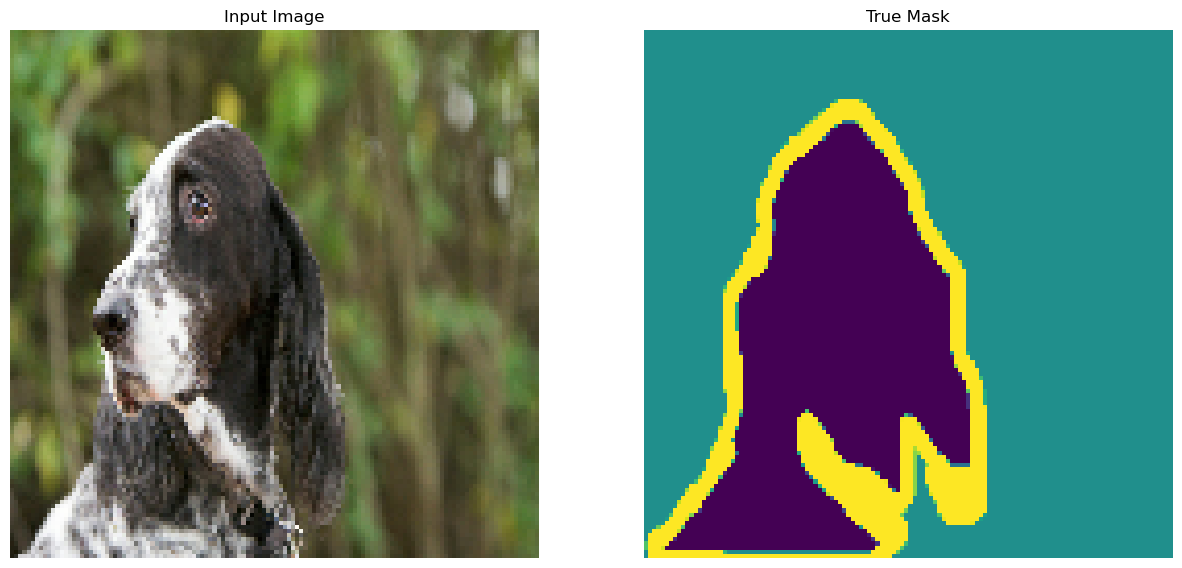

In [ ]:
for image, mask in train.take(50):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
# loading pre trained model
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3), include_top=False)

names = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu',
         'block_13_expand_relu', 'block_16_expand_relu']
layers = [base_model.get_layer(name).output for name in names]

down_sample = tf.keras.Model(base_model.input, layers)
down_sample.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
inputs = tf.keras.layers.Input(shape=[128,128,3 ])
x = inputs

# Downsampling through the model
skips = down_sample(x)
x = skips[-1]
skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
for up, skip in zip(up_stack, skips):
  x = up(x)
  concat = tf.keras.layers.Concatenate()
  x = concat([x, skip])

# This is the last layer of the model
x = tf.keras.layers.Conv2DTranspose(3, 3, strides=2 , padding='same')(x)  #64x64 -> 128x128

model = tf.keras.Model(inputs, x)

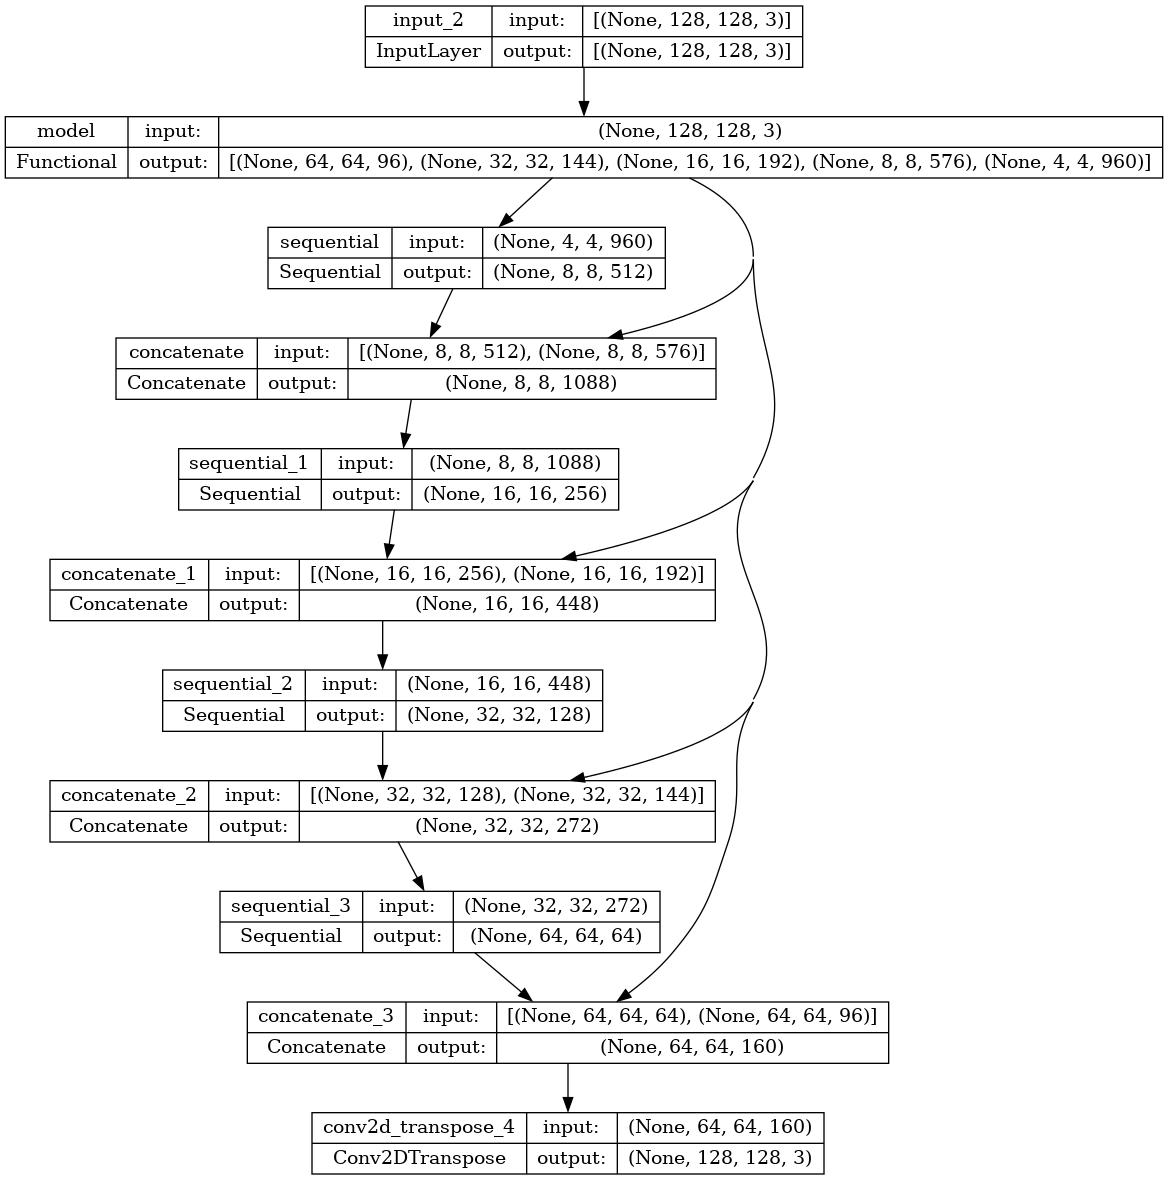

In [ ]:
#compilation of model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 9s 9s/step


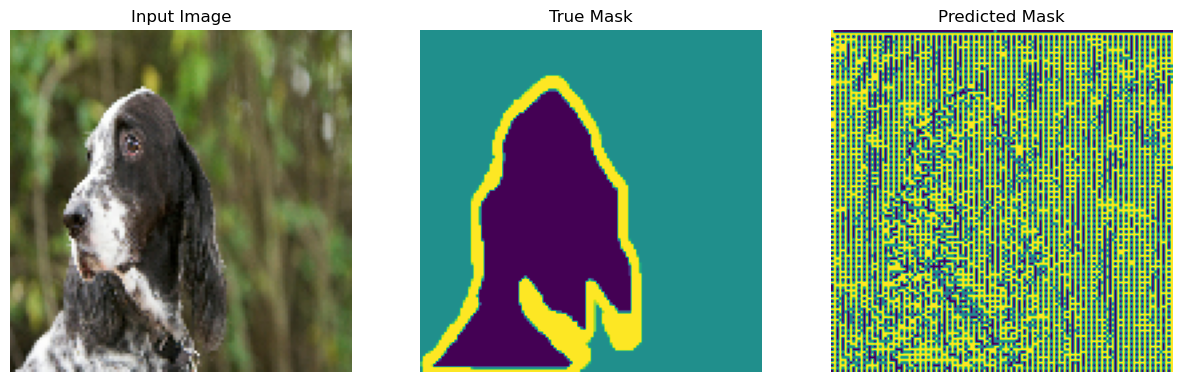

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 28ms/step


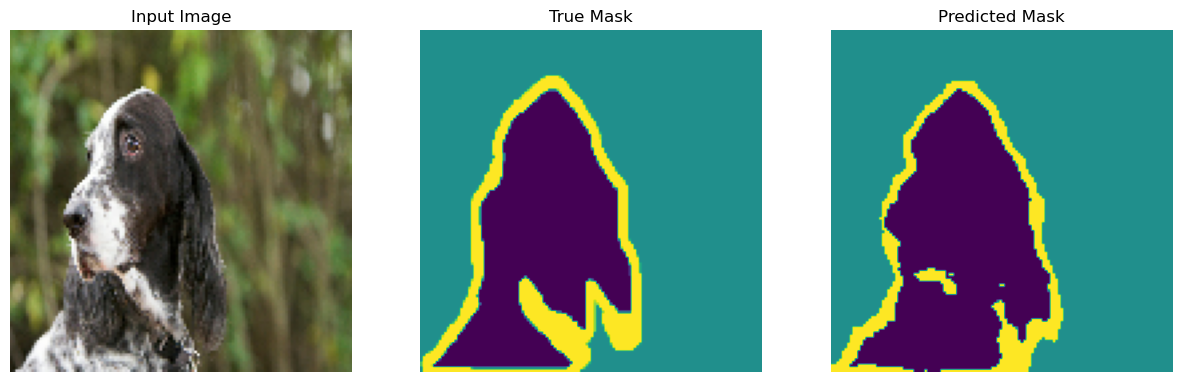


Sample Prediction after epoch 30

57/57 [==============================] - 20s 347ms/step - loss: 0.0339 - accuracy: 0.9751 - val_loss: 0.7824 - val_accuracy: 0.8818


In [ ]:
EPOCHS =  30

h = model.fit(train_dataset, 
              epochs=EPOCHS,
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_data=test_dataset,
              callbacks=[DisplayCallback()])

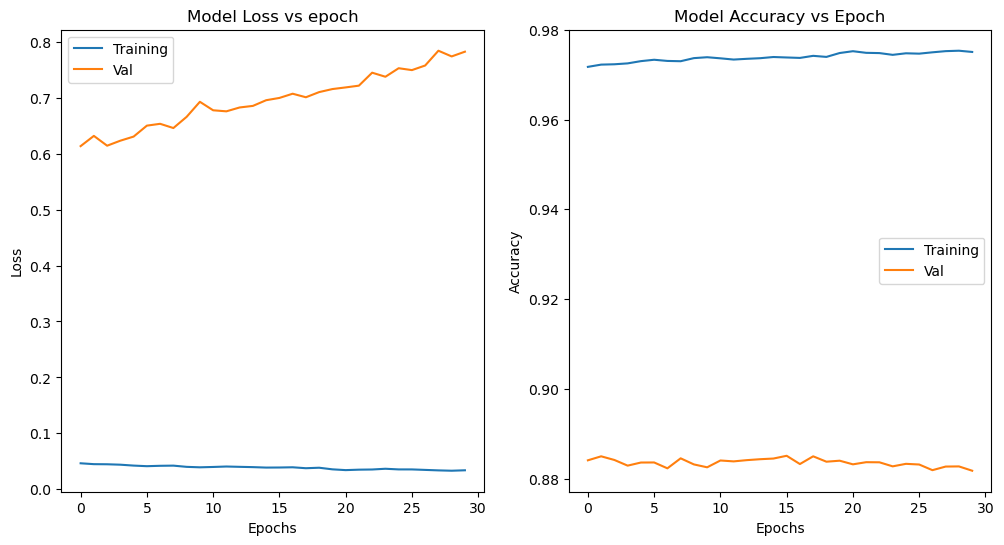

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(h.history['loss'], label='Training')
plt.plot(h.history['val_loss'], label='Val')
plt.title('Model Loss vs epoch')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(h.history['accuracy'], label='Training')
plt.plot(h.history['val_accuracy'], label='Val')
plt.title('Model Accuracy vs Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

VISUALIZING RESULTS

2/2 [==============================] - 0s 49ms/step


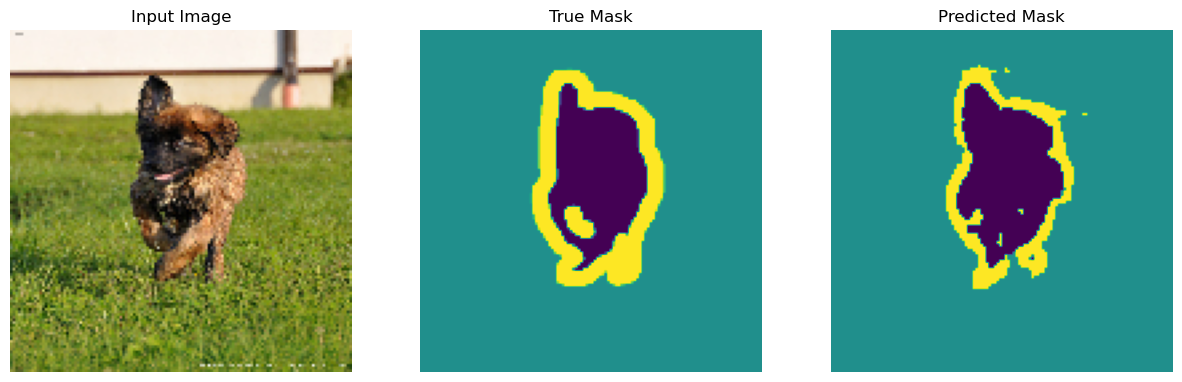

2/2 [==============================] - 0s 45ms/step


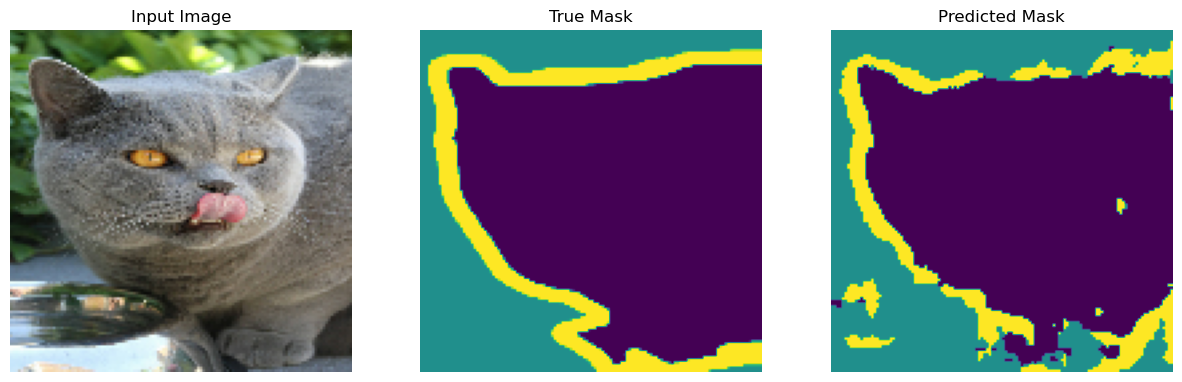

2/2 [==============================] - 0s 43ms/step


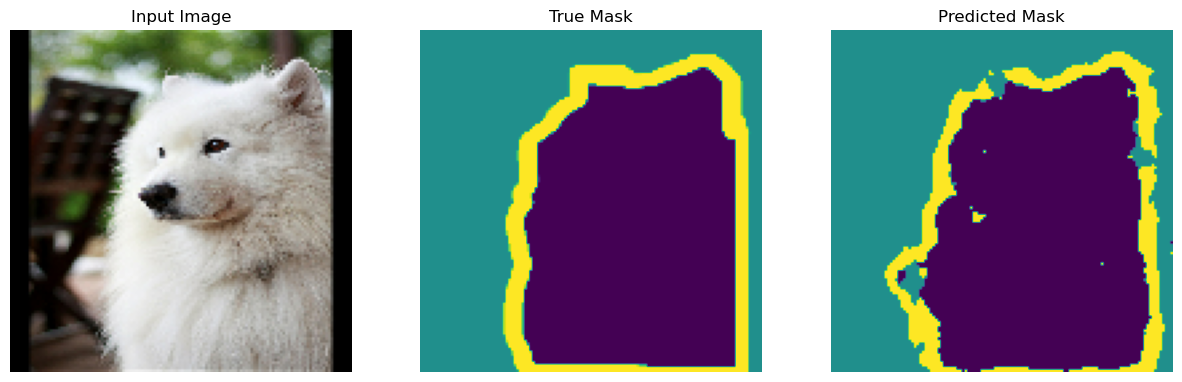

2/2 [==============================] - 0s 47ms/step


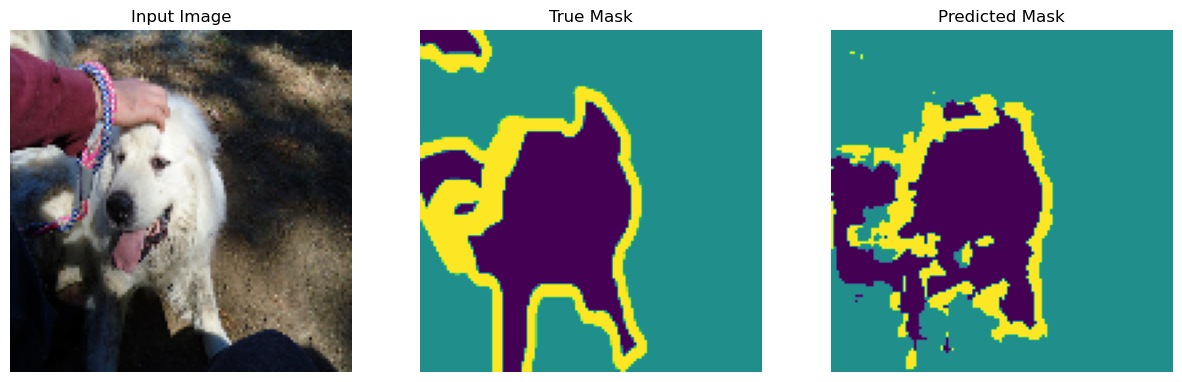

2/2 [==============================] - 0s 47ms/step


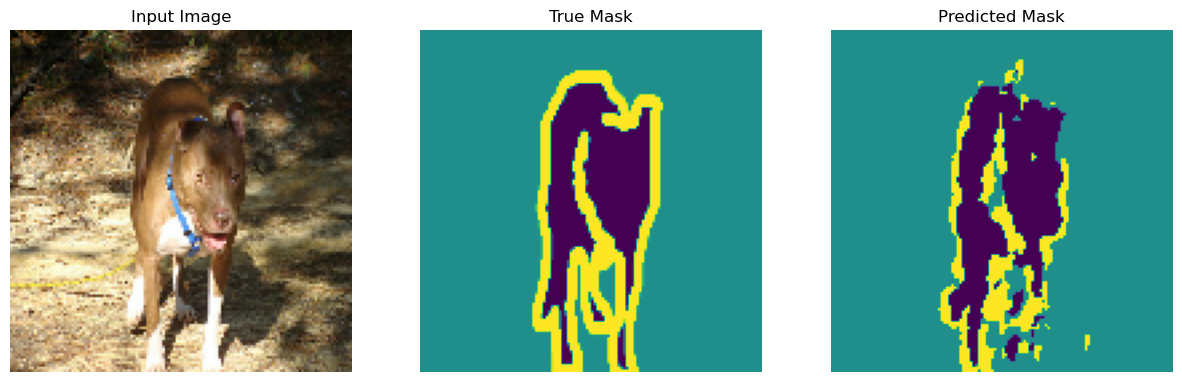

2/2 [==============================] - 0s 42ms/step


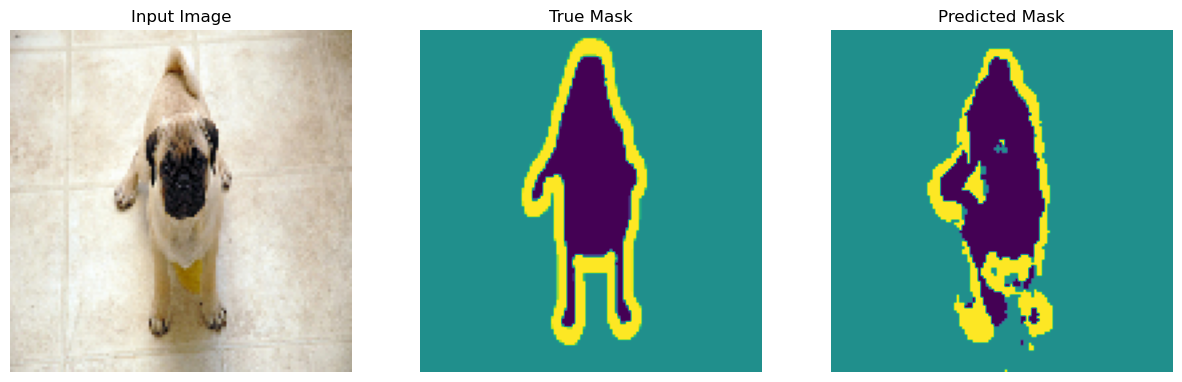

In [ ]:
show_predictions(test_dataset, 6)